$$\textrm{Joaquin Peñuela Parra}$$
$$\textrm{University of Los Andes}$$
$$\textrm{High Energy Physics Group: Phenomenology of Particles}$$

This code was written to be running in Docker. If you do not have a Docker inside hep-server2 please refer to: https://github.com/Phenomenology-group-uniandes/Tutoriales_Generales

$\textbf{Preliminaries}$ 

The libraries used here are:

In [1]:
import os
import subprocess
import numpy as np
import pandas as pd
from itertools import product
from multiprocessing import Pool
from ROOT import TCanvas
from ROOT import TPad
import matplotlib.pyplot as plt

## IMPORTANT: Make sure that "Uniandes_Framework" is in .gitignore
framework_path = "Uniandes_Framework"

if os.path.exists(framework_path):
    # Pull updates if the framework is already cloned
    try:
        subprocess.run(["git", "-C", framework_path, "pull"])
    except subprocess.CalledProcessError as e:
        raise Exception(f"Error occurred while pulling updates from the framework: {e}")
else:
    # Clone the framework if it is not already cloned
    try:
        subprocess.run(["git", "clone", "git@github.com:Phenomenology-group-uniandes/Uniandes_Framework.git"])
    except subprocess.CalledProcessError as e:
        raise Exception(f"Error occurred while cloning the framework: {e}")
from Uniandes_Framework.delphes_reader.lhereader import LHE_Loader, readLHEF, get_event_by_child
from Uniandes_Framework.delphes_reader.root_analysis import get_kinematics_row, make_histograms, overlap_histos, Quiet, generate_csv, sum_histos, histos_matplotlib, write_root_file, write_txt_file_with_high_per_bin

Welcome to JupyROOT 6.22/06


hint: Pulling without specifying how to reconcile divergent branches is
hint: discouraged. You can squelch this message by running one of the following
hint: commands sometime before your next pull:
hint: 
hint:   git config pull.rebase false  # merge (the default strategy)
hint:   git config pull.rebase true   # rebase
hint:   git config pull.ff only       # fast-forward only
hint: 
hint: You can replace "git config" with "git config --global" to set a default
hint: preference for all repositories. You can also pass --rebase, --no-rebase,
hint: or --ff-only on the command line to override the configured default per
hint: invocation.


Already up to date.


In [2]:
Folder = 'Data_SDE_2'

Betards = ['woRHC']
zp_limits = ['zp_upper_limit', 'zp_lower_limit']

In [3]:
Folder[5:]

'SDE_2'

In [4]:
generation_options = {'ta_ta_virtual_contribution':  'generate p p > ta ta QED = 0 / zp', 
                      'ta_ta_real_contribution': 'generate p p > zp, zp > ta ta QED = 0',
                      'ta_ta_total_contribution': 'generate p p > ta ta QED = 0'}

In [5]:
M_Us = np.arange(3000,3500,500)
g_Us = np.arange(0.5,1.5,0.5)
g_Zps = np.arange(0.5,2,0.5)

In [6]:
def read_xs_from_html(signal, mu_gu_gzp_label, Betard, zp_limit):
    html_path = os.path.join(os.getcwd(), Folder, Betard, zp_limit, signal,  mu_gu_gzp_label, 'crossx.html')
    html_table = pd.read_html(html_path)
    column_xs = html_table[0]['Cross section (pb)']
    return float(column_xs[0].split(' ')[0])    

In [7]:
generation_options = {'ta_ta_virtual_contribution':  'generate p p > ta ta QED = 0 $$ zp', 
                      'ta_ta_real_contribution': 'generate p p > zp > ta ta QED = 0',
                      'ta_ta_total_contribution': 'generate p p > ta ta QED = 0'}

In [8]:
Kinematic_information = {'woRHC':{'zp_upper_limit':{}, 'zp_lower_limit':{}}}

for mu , gu, gzp, Betard, zp_limit in product(M_Us,g_Us, g_Zps, Betards, zp_limits): 
    
    label = f'mu_{mu}_gu_{gu}_gzp_{gzp}'
    Kinematic_information[Betard][zp_limit][label] = {}
    
    for signal in generation_options.keys(): 
        
        # if not os.path.exists(CSV_File_path): read_lhe_file(signal)
        CSV_File_path = os.path.join(Folder, Betard, zp_limit, signal, label, 'Kinematic_Information.csv')
        Kinematic_information[Betard][zp_limit][label][signal] = pd.read_csv(CSV_File_path)

In [9]:
# Kinematic_information

In [10]:
default_hist_bins_dict={
    # "#Delta{R}":[96,0,7],
    # "#Delta{#eta}":[80,-5,5],
    # "#Delta{#phi}":[52,-3.25,3.25],
    # "#Delta{pT}":[120, 0.0, 1500.0],
    # "#Delta{#vec{pT}}":[240, 0.0, 4800.0],
    # "#Delta{#vec{p}}":[240, 0.0, 4800.0],
    # "MET(GeV)":[80, 0.0, 1000.0],
    # "pT_": [160, 0.0, 2000.0],
    # "sT(GeV)": [200, 0.0, 4000.0],
    # "mT(GeV)": [200, 0.0, 4000.0],
    # "#eta_":[80, -5, 5],
    # "#phi_":[128, -3.2, 3.2],
    # "Energy_":[80, 0.0, 1000.0],
    "m_ll(GeV)" : [60, 0, 3000.0]
}

In [11]:
legends = {'ta_ta_virtual_contribution': 'non-res','ta_ta_real_contribution':'zp','ta_ta_total_contribution':'total'}

In [12]:
# !rm -rf Histograms/

In [13]:
Histograms_1 = {'woRHC':{'zp_upper_limit':{}, 'zp_lower_limit':{}}}
Histograms_2 = {'woRHC':{'zp_upper_limit':{}, 'zp_lower_limit':{}}}
Histograms_3 = {'woRHC':{'zp_upper_limit':{}, 'zp_lower_limit':{}}}
Histograms_4 = {'woRHC':{'zp_upper_limit':{}, 'zp_lower_limit':{}}}
Histograms_5 = {'woRHC':{'zp_upper_limit':{}, 'zp_lower_limit':{}}}

for mu , gu, gzp, Betard, zp_limit in product(M_Us,g_Us, g_Zps, Betards, zp_limits):
    
    label = f'mu_{mu}_gu_{gu}_gzp_{gzp}'
    
    Histograms_1[Betard][zp_limit][label] = {legends['ta_ta_total_contribution']:{}, 'non-res + zp': {}, 'non-res': {}}
    Histograms_2[Betard][zp_limit][label] = {legends['ta_ta_virtual_contribution']: {}, legends['ta_ta_real_contribution']: {}}
    Histograms_3[Betard][zp_limit][label] = {'(non-res + zp)/total': {}}
    Histograms_4[Betard][zp_limit][label] = {'non-res/total': {}}
    Histograms_5[Betard][zp_limit][label] = {'Interference': {}}
    
    #Normalized by 1:
    # Histograms_1[Betard][zp_limit][label][legends['ta_ta_total_contribution']] = make_histograms(Kinematic_information[Betard][zp_limit][label]['ta_ta_total_contribution'], hist_bins_dict = default_hist_bins_dict)
    # Histograms_2[Betard][zp_limit][label][legends['ta_ta_virtual_contribution']] = make_histograms(Kinematic_information[Betard][zp_limit][label]['ta_ta_virtual_contribution'], hist_bins_dict = default_hist_bins_dict)
    # Histograms_2[Betard][zp_limit][label][legends['ta_ta_real_contribution']] = make_histograms(Kinematic_information[Betard][zp_limit][label]['ta_ta_real_contribution'], hist_bins_dict = default_hist_bins_dict)
     
    #Normalized by XS:
    Histograms_1[Betard][zp_limit][label][legends['ta_ta_total_contribution']] = make_histograms(Kinematic_information[Betard][zp_limit][label]['ta_ta_total_contribution'], hist_bins_dict = default_hist_bins_dict, integral = read_xs_from_html('ta_ta_total_contribution', label, Betard, zp_limit))
    Histograms_2[Betard][zp_limit][label][legends['ta_ta_virtual_contribution']] = make_histograms(Kinematic_information[Betard][zp_limit][label]['ta_ta_virtual_contribution'], hist_bins_dict = default_hist_bins_dict, integral = read_xs_from_html('ta_ta_virtual_contribution', label, Betard, zp_limit))
    Histograms_2[Betard][zp_limit][label][legends['ta_ta_real_contribution']] = make_histograms(Kinematic_information[Betard][zp_limit][label]['ta_ta_real_contribution'], hist_bins_dict = default_hist_bins_dict, integral = read_xs_from_html('ta_ta_real_contribution', label, Betard, zp_limit))

    for key in Histograms_1[Betard][zp_limit][label][legends['ta_ta_total_contribution']].keys(): 
        
        Histograms_1[Betard][zp_limit][label]['non-res + zp'][key] = sum_histos([Histograms_2[Betard][zp_limit][label][legends['ta_ta_virtual_contribution']][key], Histograms_2[Betard][zp_limit][label][legends['ta_ta_real_contribution']][key]])
        Histograms_3[Betard][zp_limit][label]['(non-res + zp)/total'][key] = Histograms_1[Betard][zp_limit][label]['non-res + zp'][key]/Histograms_1[Betard][zp_limit][label][legends['ta_ta_total_contribution']][key]
        Histograms_5[Betard][zp_limit][label]['Interference'][key] =  sum_histos([Histograms_1[Betard][zp_limit][label][legends['ta_ta_total_contribution']][key], Histograms_1[Betard][zp_limit][label]['non-res + zp'][key]], substract = True)
        
        # Histograms_1[Betard][zp_limit][label]['non-res'][key] = Histograms_2[Betard][zp_limit][label][legends['ta_ta_virtual_contribution']][key]
        # Histograms_4[Betard][zp_limit][label]['non-res/total'][key] = Histograms_2[Betard][zp_limit][label][legends['ta_ta_virtual_contribution']][key]/Histograms_1[Betard][zp_limit][label][legends['ta_ta_total_contribution']][key]

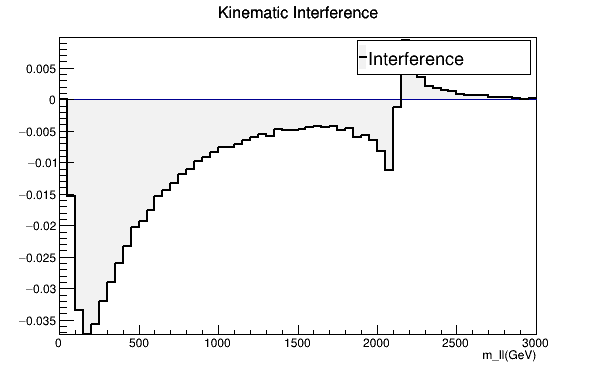

In [14]:
format_figure = '.png'

for mu , gu, gzp, Betard, zp_limit in product(M_Us,g_Us, g_Zps, Betards, zp_limits): #It takes 3 minutes by combination
    
    with Quiet():
    
        label = f'mu_{mu}_gu_{gu}_gzp_{gzp}'

        Hist_to_save = {}
        os.makedirs(os.path.join(f'Histograms_{Folder[5:]}', Betard, zp_limit), exist_ok=True)

        histos1, canvas, legend1 = overlap_histos("m_ll(GeV)", dict_histos= Histograms_1[Betard][zp_limit][label], log_scale= True)
        for n, histo in enumerate(histos1):
            histo.Scale(1/histo.Integral())
            Hist_to_save[list(Histograms_1[Betard][zp_limit][label].keys())[n]] = histo
        canvas.Update()    
        canvas.SaveAs(f'Histograms_{Folder[5:]}/{Betard}/{zp_limit}/{label}_Total_and_non-res+zp{format_figure}') 

        histos2, canvas, legend2 = overlap_histos("m_ll(GeV)", dict_histos= Histograms_2[Betard][zp_limit][label], log_scale= True)
        for n, histo in enumerate(histos2):
            histo.Scale(1/histo.Integral())
            Hist_to_save[list(Histograms_2[Betard][zp_limit][label].keys())[n]] = histo
        canvas.Update()   
        canvas.SaveAs(f'Histograms_{Folder[5:]}/{Betard}/{zp_limit}/{label}_non-ress_and_zp{format_figure}') 

        histos3, canvas, legend3 = overlap_histos("m_ll(GeV)", dict_histos= Histograms_3[Betard][zp_limit][label], log_scale= True)
        for n, histo in enumerate(histos3):
            #histo.Scale(1/histo.Integral())
            histo.SetTitle(f'; m_ll(GeV);')
            Hist_to_save[list(Histograms_3[Betard][zp_limit][label].keys())[n].replace('/', '_')] = histo
        canvas.Update()   
        canvas.SaveAs(f'Histograms_{Folder[5:]}/{Betard}/{zp_limit}/{label}_Division_non-res+zp_and_total{format_figure}') 

        histos5, canvas, legend5 = overlap_histos("m_ll(GeV)", dict_histos= Histograms_5[Betard][zp_limit][label])
        for n, histo in enumerate(histos5):
            histo.Scale(1/read_xs_from_html('ta_ta_total_contribution', label, Betard, zp_limit))
            # histo.GetYaxis().SetRangeUser(-0.06,0.01)
            histo.SetTitle(f'; m_ll(GeV);')
            Hist_to_save[list(Histograms_5[Betard][zp_limit][label].keys())[n]] = histo
        canvas.Update()   
        canvas.SaveAs(f'Histograms_{Folder[5:]}/{Betard}/{zp_limit}/{label}_Kinematic_Interference{format_figure}') 
        
        
        #Subplots:
        
        CANVAS_Subplots = TCanvas('','', 1200, 1600)    
        Division = TPad('','', 0, 0, 1, 1, 0, 0 ,0)
        Division.SetFillStyle(4000)
        Division.Draw()
        Division.Divide(2,4, 0.01, 0.01, 0)
        
        Division.cd(1).SetLogy()
        histos1.Draw("histnostack")
        legend1.Draw('same')
        Division.cd(2).SetLogy()
        histos2.Draw("histnostack")
        legend2.Draw('same')
        Division.cd(3).SetLogy()
        histos3.Draw("histnostack")
        histos3.SetTitle(f'(non-res + zp)/total; m_ll(GeV);')        
        Division.cd(4)
        histos5.Draw("histnostack")
        histos5.SetTitle(f'Kinematic Interference; m_ll(GeV);')        
        
        CANVAS_Subplots.Print(f'Histograms_{Folder[5:]}/{Betard}/{zp_limit}/{label}_All_Histograms{format_figure}') 
        write_txt_file_with_high_per_bin(file_name= os.path.join(f'Histograms_{Folder[5:]}',Betard, zp_limit,f'{label}'), Dict_Hist= Hist_to_save) 

In [15]:
# Hist_to_save

In [16]:
# from ROOT import TCanvas #It is necessary to show plots with ROOT.
# from ROOT import TPad

In [17]:
# canvas_pruebas = TCanvas('','', 600, 400)
# Hist_to_save['Interference'].GetYaxis().SetRangeUser(-0.06,0.01)
# Hist_to_save['Interference'].SetTitle(f'Interference; m_ll(GeV);')
# Hist_to_save['Interference'].SetStats(0)
# Hist_to_save['Interference'].Draw('hist')
# canvas_pruebas.Draw()

In [18]:
# canvas_pruebas = TCanvas('','', 600, 800)

# # canvas_pruebas.cd()
# # canvas_pruebas.Divide(1,2, 0.01, 0.01, 0)

# Division = TPad('','', 0, 0, 1, 1, 0, 0 ,0)
# Division.SetFillStyle(4000)
# Division.Draw()
# Division.Divide(1,2, 0.01, 0.01, 0)

# Division.cd(1).SetLogy()
# Hist_to_save['Interference'].Draw('hist')
# Division.cd(2)
# Hist_to_save['non-res + zp-onshell'].Draw('hist')

# canvas_pruebas.Print('prueba.png') 